In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [96]:
BASE_DIR = '..'
RESULTS_DIR = os.path.join(BASE_DIR,'cami2_benchmark', 'model_results')
OUT_DIR = os.path.join(BASE_DIR, 'figures')

In [ ]:
COMPLETENESS_BINS = [90, 80, 70, 60, 50]
LABELS = [">90%", ">80%", ">70%", ">60%", ">50%"]
COLORS = ["#004c6d", "#2a7f97", "#52a9ba", "#a7d6db"] 

def parse_quality_report(file_path):
    """Parses a CheckM2 quality report and extracts completeness & contamination."""
    df = pd.read_csv(file_path, sep="\t")
    df = df[df["Contamination"] < 5]  
    return df["Completeness"].values


def process_all_reports(results_dir):
    """Walks through the RESULTS_DIR to collect all models and datasets."""
    data = {}
    
    for dataset in os.listdir(results_dir):
        dataset_path = os.path.join(results_dir, dataset, "checkm2")
        if not os.path.isdir(dataset_path):
            continue

        for model in os.listdir(dataset_path):
            report_path = os.path.join(dataset_path, model, "quality_report.tsv")
            if not os.path.isfile(report_path):
                continue

            completeness_values = parse_quality_report(report_path)
            bin_counts = [np.sum(completeness_values >= b) for b in COMPLETENESS_BINS]

            if dataset not in data:
                data[dataset] = {}
            data[dataset][model] = bin_counts
    
    return data

In [109]:
data = process_all_reports(RESULTS_DIR)

In [110]:
data

{'airways_short': {'comebin_results': [178, 187, 207, 229, 246],
  'dnaberts_results': [0, 2, 6, 11, 17],
  'taxvamb_results': [36, 42, 51, 70, 76],
  'vamb_results': [29, 36, 43, 52, 57]},
 'gastro_short': {'comebin_results': [213, 237, 245, 258, 280],
  'taxvamb_results': [60, 64, 67, 70, 73],
  'vamb_results': [51, 59, 61, 64, 67]},
 'metahit': {'dnaberts0_results': [1, 8, 11, 16, 22],
  'dnaberts250000_results': [1, 8, 11, 16, 22],
  'tnf_results': [0, 1, 1, 1, 2]},
 'oral_short': {'comebin_results': [269, 284, 301, 321, 339],
  'taxvamb_results': [35, 43, 45, 47, 57],
  'vamb_results': [35, 44, 45, 48, 54]},
 'plant_short': {'comebin_results': [24, 28, 29, 31, 33],
  'taxvamb_results': [2, 2, 3, 3, 4],
  'vamb_results': [2, 5, 5, 6, 6]},
 'skin_short': {'comebin_results': [230, 262, 305, 328, 346],
  'taxvamb_results': [54, 69, 105, 121, 123],
  'vamb_results': [36, 47, 57, 69, 72]},
 'urogenital_short': {'comebin_results': [157, 167, 183, 198, 210],
  'taxvamb_results': [39, 43, 

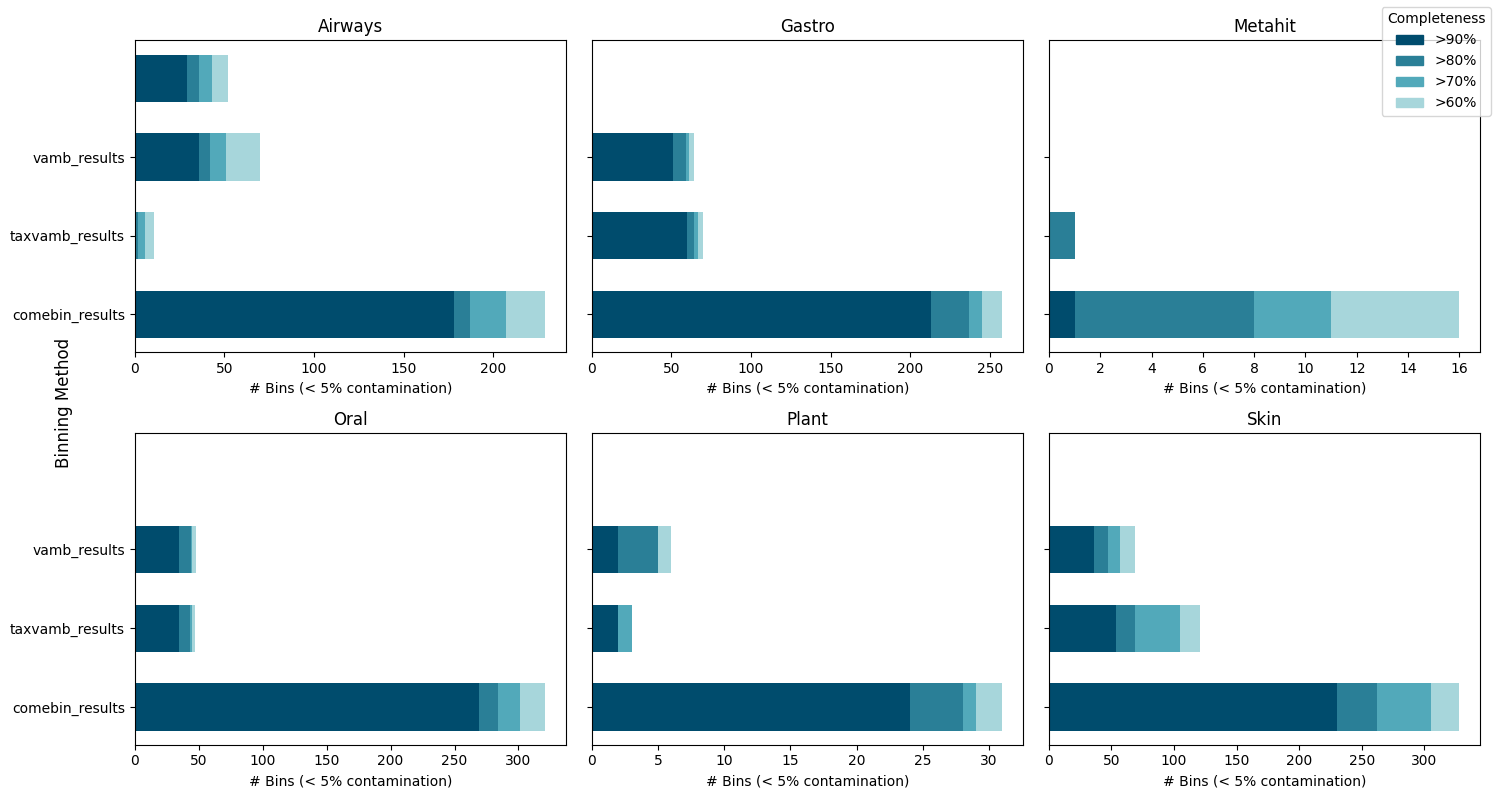

In [105]:
datasets = sorted(data.keys())
num_datasets = len(datasets)


# Create a 2x3 grid for the subplots
fig, axes = plt.subplots(2, 3, figsize=(15, 8), sharey=True)
axes = axes.flatten()

for ax, dataset in zip(axes, datasets):
    models = data[dataset]

    # Extract max values per method
    model_methods = list(models.keys())
    max_values = [models[m] for m in model_methods]  # Keep all completeness bins

    # Convert to NumPy array and compute difference from first bar
    bin_counts = np.array(max_values)  # Shape (3, 4) for 3 methods and 4 completeness bins

    y_positions = np.arange(len(model_methods))  # Vertical positioning
    bar_width = 0.6  # Make bars slimmer

    for i, (method, y) in enumerate(zip(model_methods, y_positions)):
        last_value = 0  # Keeps track of the previous bar height

        for bin_idx, (value, color) in enumerate(zip(bin_counts[i], COLORS)):
            bar_length = value - last_value  # Difference from previous bin
            ax.barh(y, bar_length, left=last_value, color=color, height=bar_width)

            last_value = value  # Update the last value for the next bin

    ax.set_yticks(y_positions)
    ax.set_yticklabels(model_methods, fontsize=10)
    ax.set_title(dataset.replace("_short", "").capitalize(), fontsize=12)
    ax.set_xlabel("# Bins (< 5% contamination)", fontsize=10)

# Common y-axis label
fig.text(0.04, 0.5, "Binning Method", va="center", rotation="vertical", fontsize=12)

# Legend (only once, outside)
handles = [plt.Rectangle((0,0),1,1, color=c) for c in COLORS]
fig.legend(handles, COMPLETENESS_LABELS, title="Completeness", loc="upper right", fontsize=10)

plt.tight_layout()
plt.show()